# Librerías necesarias

In [1]:
import sys
sys.path.append('../..')

from utils import load_cinema_reviews

import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

import matplotlib.pyplot as plt

# Carga de datos

In [2]:
# Path al directorio donde tenemos los datasets con las reviews
# ¡Descomprimir antes!
datasets_path = '../../datasets'
corpus_cine_folder = 'corpusCine'

In [3]:
reviews_dict = load_cinema_reviews(datasets_path, corpus_cine_folder)

In [4]:
reviews_dict.get(10)

{'author': 'Javier Moreno',
 'title': 'Harry poter y el caliz de fuego',
 'sentiment': '4',
 'summary': 'Interesante adaptación de la novela de Rowling',
 'review_text': 'No. Esta vez no voy a usar una película como pretexto para exponer mis ideas o pensamientos mas dementes/racionales/insensatos. Esta vez, y lo juro ante el sagrado Necronomicón de Lovecraft, pienso hablar de la película en si (por primera vez y esperando que no sirva de precedente), aunque creo que es evidente que prefiero que una película me haga reflexionar sobre cualquier aspecto que en ella se de cita. Quizas algún dia hable sobre todo lo que significa la saga de novelas de Rowling (anda que no tengo cosas de las que hablar) desde una perspectiva menos mitológica y mas profunda.Parto de la base de que soy un autentico fan de los libros, los adoro, me parecen de lo mejorcito que ha salido en fantasia, con un personaje principal realmente interesante y atormentado a todos los niveles por todo lo que su no-existencia

In [5]:
reviews_text = []
reviews_sentiment = []

for review in reviews_dict.values():
    reviews_text.append(review.get('review_text'))
    reviews_sentiment.append(review.get('sentiment'))

df = pd.DataFrame({
    'review': reviews_text,
    'sentiment': reviews_sentiment
})
df.dropna(subset=['review', 'sentiment'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
df.head()

,review,sentiment
0,Cada vez me gusta menos el cine de masas. Las ...,1
1,"El otro dia fui a ver ""la de los sioux"" como d...",3
2,"Es que no la cagan en ninguna, todas las pelis...",5
3,Es un dolor esto del cine. Yo ya voy con miedo...,2
4,"Tras una insufrible primera media hora, la cas...",2


In [7]:
def label_sentiment(row):
    if int(row['sentiment']) < 3:
        return 'neg'
    else:
        return 'pos'

In [8]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)

In [9]:
df.head()

,review,sentiment,sentiment_label
0,Cada vez me gusta menos el cine de masas. Las ...,1,neg
1,"El otro dia fui a ver ""la de los sioux"" como d...",3,pos
2,"Es que no la cagan en ninguna, todas las pelis...",5,pos
3,Es un dolor esto del cine. Yo ya voy con miedo...,2,neg
4,"Tras una insufrible primera media hora, la cas...",2,neg


# Separamos en conjunto de train y test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df['review'],
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [12]:
X_train.iloc[:10]

1924    Zhang Yimou ya no es el poeta de lo íntimo, el...
3250    Las aventuras amorosas del joven Molire es el ...
1620    El cientifismo naturalista es un género cinema...
907     Quizá esperaba una crítica más demoledora del ...
1864    Colateral de Michael Mann desnuda con claridad...
3007    No es Gracia Querejeta una directora a la que ...
1583    Esta es una de esas extrañas películas que emp...
370     Suele ocurrir que cuando alguien pone las expe...
2045    Vivian vive en Bucarest, trabaja en una tienda...
3601    Algunos filmes pasan a ser de culto por un hec...
Name: review, dtype: object

In [13]:
y_train.iloc[:10]

1924    pos
3250    pos
1620    neg
907     neg
1864    pos
3007    pos
1583    pos
370     pos
2045    neg
3601    neg
Name: sentiment_label, dtype: object

# Extracción de features

In [52]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(2, 3)
)
cv.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=2500, min_df=5,
        ngram_range=(2, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='ascii', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [53]:
print(list(cv.vocabulary_.items())[:20])

[('ya no', 2494), ('no es', 1566), ('es el', 844), ('de lo', 347), ('el director', 579), ('en los', 758), ('los primeros', 1429), ('de una', 437), ('es un', 873), ('consiste en', 213), ('ejercicio de', 549), ('bajo el', 90), ('el que', 652), ('una forma', 2395), ('forma de', 967), ('el cine', 562), ('cine la', 150), ('la que', 1262), ('que no', 1948), ('de esta', 290)]


In [54]:
print(len(cv.vocabulary_))

2500


## TF-IDF scores del training set y test set

In [55]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

## Score IDF de algunas palabras

In [56]:
words_example = [
    'cine',
    'pelicula',
    'muy',
    'y',
    'de',
    'que',
    'potter',
    'mala',
    'aburrimiento',
    'sorprendente',
    'aburrir',
    'ausdf'
]

In [57]:
vocab_idf = dict(zip(cv.get_feature_names(), cv.idf_))

print('{0:20}{1:20}'.format('Palabra', 'IDF'))
for word in words_example:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))

Palabra             IDF                 
cine                OOV                 
pelicula            OOV                 
muy                 OOV                 
y                   OOV                 
de                  OOV                 
que                 OOV                 
potter              OOV                 
mala                OOV                 
aburrimiento        OOV                 
sorprendente        OOV                 
aburrir             OOV                 
ausdf               OOV                 


## Palabras con el TF-IDF en alguna review

In [58]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 978
Sentiment: neg
Review: El director John Carpenter debe preguntarse ¿Qué hice yo para merecer esto? Con los remakes anteriores perpretados a mayor gloria de dos de sus grandes obras La niebla y Asalto a la comisaría 13. Que al parecer se rodaron para destrozar los originales, si esa no fue la intención es como salio.Parecía que el de halloween podía correr mejor suerte, primero se contrata un director que causa una gran impresión con sus anteriores trabajos. Por supuesto Rob Zombie se asentaba en el mundo de autores de género con las credenciales de la casa de los mil cadáveres y secuela.Encima un reparto lleno de grandes interpretes conocidos para el aficionado. Gente como BRAD DOURIF Combustión espontánea KEN FOREE Zombie, ADRIENNE BARBEAU La Niebla o el gran MALCOM MCDOWELL La naranja mecánica además de SID HAIG y otros actores vistos en los filmes anteriores del director. Más de uno se frotaba las manos con el resultado.Pues señores dejen de frotarlas porque se vuelve a ases

In [59]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 978:
                  tfidf
con los        0.172781
fue la         0.152264
dos de         0.151696
el trabajo de  0.151137
se vuelve      0.150051
por lo demas   0.150051
sin el         0.149522
de genero      0.149522
las manos      0.149002
porque se      0.148490

Top 10 words with lowest TF_IDF in the review 978:
           tfidf
de sus  0.069993
en los  0.064813
que es  0.061298
es un   0.059423
con el  0.058699
es una  0.056329
que el  0.052902
en el   0.040167
de los  0.039995
de la   0.033410


## $\chi²$ scores

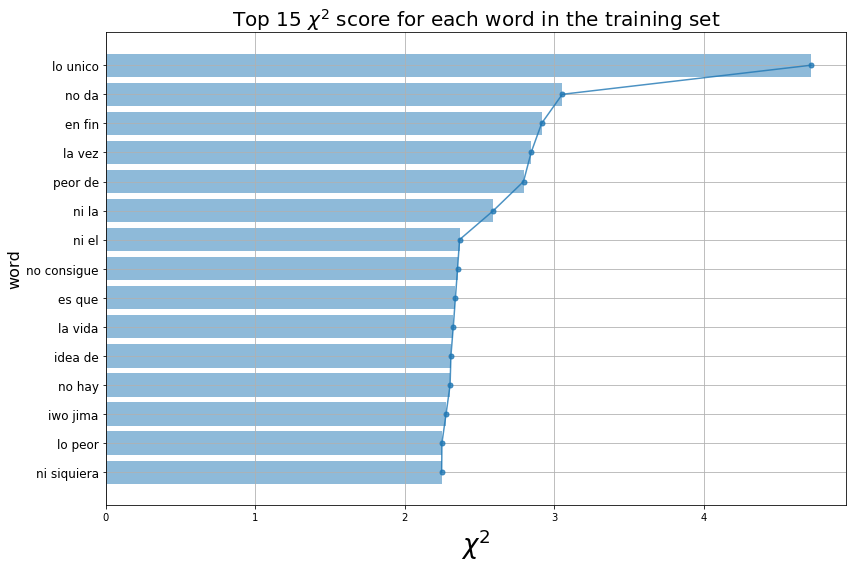

In [60]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

# Entrenamiento

In [61]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.6597938144329897
Accuracy for C=0.05: 0.6597938144329897
Accuracy for C=0.25: 0.6649484536082474
Accuracy for C=0.5: 0.7030927835051546
Accuracy for C=1: 0.7422680412371134
Accuracy for C=10: 0.7329896907216494
Accuracy for C=100: 0.6989690721649484
Accuracy for C=1000: 0.6845360824742268
Accuracy for C=10000: 0.6804123711340206


# Algunas métricas

In [62]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[183 147]
 [163 477]]

Classification report:
              precision    recall  f1-score   support

         neg       0.53      0.55      0.54       330
         pos       0.76      0.75      0.75       640

   micro avg       0.68      0.68      0.68       970
   macro avg       0.65      0.65      0.65       970
weighted avg       0.68      0.68      0.68       970

Accuracy score:0.6804123711340206


In [48]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[188 142]
 [ 94 546]]

Classification report:
              precision    recall  f1-score   support

         neg       0.67      0.57      0.61       330
         pos       0.79      0.85      0.82       640

   micro avg       0.76      0.76      0.76       970
   macro avg       0.73      0.71      0.72       970
weighted avg       0.75      0.76      0.75       970

Accuracy score:0.756701030927835


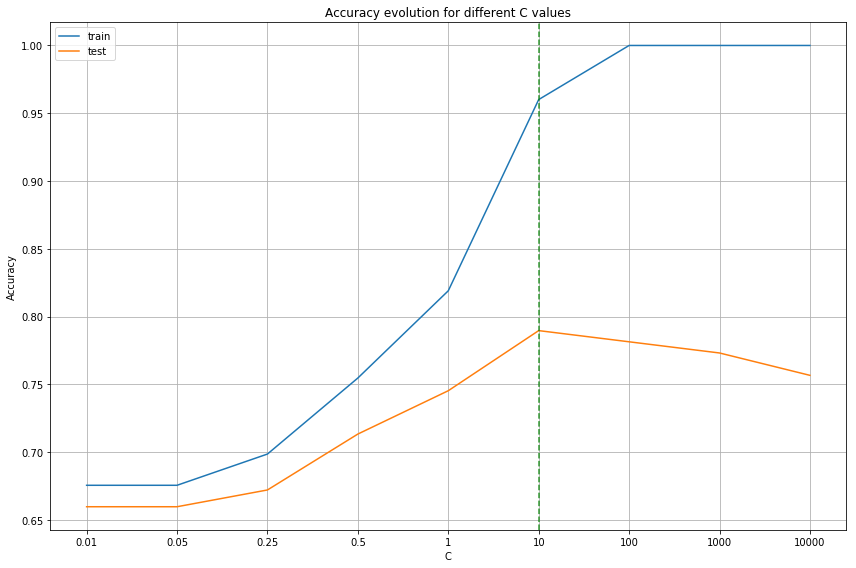

In [49]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

# Predict

In [50]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index]['sentiment_label']))
    r = df.iloc[review_index]['review']
    print('Prediction: {}'.format(lr.predict(cv.transform([r]))))

In [51]:
for i in random.sample(range(0, len(df)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 2481
Actual sentiment: pos
Prediction: ['pos']

Review no. 1845
Actual sentiment: pos
Prediction: ['pos']

Review no. 274
Actual sentiment: pos
Prediction: ['pos']

Review no. 2198
Actual sentiment: neg
Prediction: ['neg']

Review no. 1847
Actual sentiment: pos
Prediction: ['pos']
